In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Some Reference
https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt
http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# Dataset loading

In [48]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 665)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bendlength_bend_edge_length_std_04,bendlength_bend_edge_length_min_04,bendlength_bend_edge_length_max_04,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,163.73709,29.010676,594.972659,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0.00000,0.000000,0.000000,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0.00000,0.000000,0.000000,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0.00000,0.000000,0.000000,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0.00000,0.000000,0.000000,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [49]:
#dataset.columns.values

In [50]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

dataset.shape

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
temp --> 5326
bendlength_deformation_length_00 --> 296
bendlength_deformation_length_01 --> 112
bendlength_deformation_length_02 --> 3
bendlength_deformation_length_03 --> 1
Done !


(5401, 665)

In [51]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('benddxf_')]

#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(5105, 665)

# cleaning to have at least min occurences

In [52]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        print(occ.COART)
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

dataset.shape

33
1.5 will be dropped
1
2.5 will be dropped
6
20.0 will be dropped


(5065, 665)

# Target definition

In [53]:
target = 'VAMAT'
assert target in ['VAMAT', 'VALAJOUT', 'VALTOT'], 'The target must be in y dataset'

# Is the target "normal" ?

In [54]:
from scipy.stats import skew
skew(dataset[target]) #Nope !

4.574240913134915

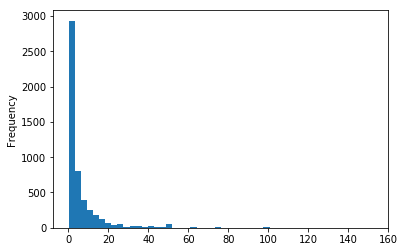

In [55]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VAMAT

In [56]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [59]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

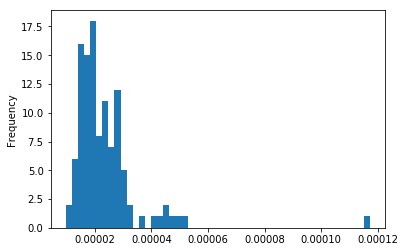

In [60]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [61]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_MPATTERN']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_MPATTERN
thickness                         
2.0       0.02            0.000013
          0.95            0.000045
3.0       0.02            0.000018
          0.95            0.000060
4.0       0.02            0.000023
          0.95            0.000089
5.0       0.02            0.000028
          0.95            0.000091
6.0       0.02            0.000033
          0.95            0.000134
8.0       0.02            0.000044
          0.95            0.000182
10.0      0.02            0.000063
          0.95            0.000248
12.0      0.02            0.000059
          0.95            0.000247
15.0      0.02            0.000085
          0.95            0.000271

In [62]:
# If vamat is target, cleaning
if target == 'VAMAT' or target == 'VALTOT':
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4704, 667)

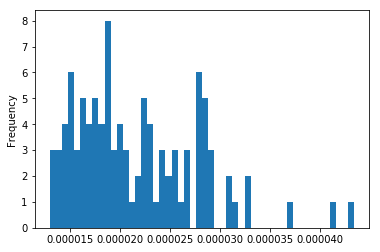

In [63]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [64]:
skew(dataset[target])

4.243692352335607

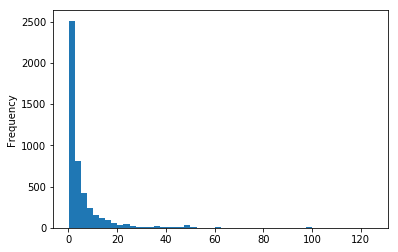

In [65]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VALAJOUT

In [66]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [67]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

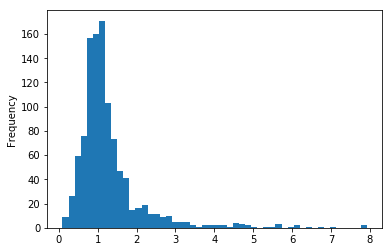

In [68]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

In [69]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.704800
                     0.95          7.743000
          1          0.02          0.515800
                     0.95          2.330000
          2          0.02          0.245067
                     0.95          2.154667
          3          0.02          0.623350
                     0.95          1.954250
          4          0.02          0.573280
                     0.95          2.137800
          5          0.02          0.224867
                     0.95          2.048667
          6          0.02          0.703314
                     0.95          1.496000
          7          0.02          0.700500
                     0.95          1.551500
          8          0.02          0.782978
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
3.0       0          0.02          0.218000
                     0.95          5.710000
          1          0.02          0.393500
                     0.95          1.483750
          2          0.02          0.405467
                     0.95          1.916500
          3          0.02          0.363850
                     0.95          2.401375
...                                     ...
10.0      0          0.02          0.592000
                     0.95          9.260000
          1          0.02          0.968600
                     0.95          4.102000
          2          0.02          0.489067
                     0.95          3.470000
          3          0.02          0.990350
                     0.95          3.877875
          4          0.02          1.137600
                     0.95          3.032000
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.570000
                     0.95          6.860500
          1          0.02          0.165000
                     0.95          2.267500
          2          0.02          0.716667
                     0.95          1.723333
          3          0.02          0.615000
                     0.95          1.041000
          4          0.02          0.848240
                     0.95          1.819400
15.0      0          0.02          0.737000
                     0.95          8.658000
          1          0.02          1.100000
                     0.95          2.962250
          2          0.02          0.853333
                     0.95          1.526667
          3          0.02          0.870000
                     0.95          1.151250

[148 rows x 1 columns]

In [70]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT' or target == 'VALTOT':
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4704, 668)

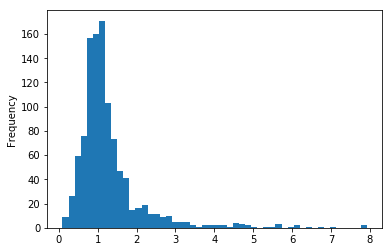

In [71]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

## Target review

In [72]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

,VAMAT
count,4704.000000
mean,5.897545
std,10.382502
min,0.110000
25%,0.810000
50%,2.270000
75%,6.260000
max,125.100000


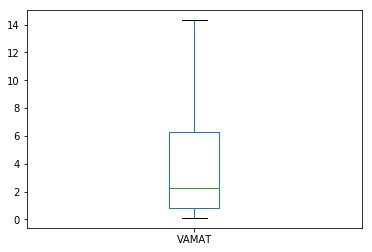

In [73]:
y[[target]].plot.box(sym='')
y[[target]].describe()

# Dataset re-ordering and Splitting

In [74]:
limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',]

# 1 Bend as a float
limitedset.append('thickness')

# 2 Thickness as categories
#limitedset.extend([x for x in dataset.columns.values if x.startswith('thick_')])

# 3 Different counts
limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

# 4 Bends in groups
#limitedset.extend([x for x in dataset.columns.values if x.startswith('bend_gr_')])

# 5 bends according DXF
#limitedset.extend([x for x in dataset.columns.values if x.startswith('benddxf_')])

# 6 according DXF, sorted by length
limitedset.extend([x for x in dataset.columns.values if x.startswith('bendlength_')])


print(len(limitedset))
limitedset

143


['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count',
 'bendlength_bend_radius_00',
 'bendlength_bend_angle_00',
 'bendlength_bend_direction_00',
 'bendlength_deformation_length_00',
 'bendlength_merged_bend_00',
 'bendlength_punch_length_00',
 'bendlength_bend_radius_01',
 'bendlength_bend_angle_01',
 'bendlength_bend_direction_01',
 'bendlength_deformation_length_01',
 'bendlength_merged_bend_01',
 'bendlength_punch_length_01',
 'bendlength_bend_radius_02',
 'bendlength_bend_angle_02',
 'bendlength_bend_direction_02',
 'bendlength_deformation_length_02',
 'bendlength_merged_bend_02',
 'bendlength_punch_length_02',
 'bendlength_bend_radius_03',
 'bendlength_bend_angle_03',
 'bendlength_bend_direction_03',
 'bendlength_deformation_length_03',
 'bendlength_merged_bend_03',
 'bendleng

In [75]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])

print(X_train.shape, X_test.shape)

#ONLY FOR DATASET CLEANING PURPOSE
#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, random_state=0 ,stratify=dataset['bend_group'])

(3292, 668) (1412, 668)


# Box_cox feature creation

In [76]:
from scipy import stats
from scipy.special import inv_boxcox
_, lmbda = stats.boxcox(y_train[target], lmbda=None)
y_train['logtarget'] = y_train[target].apply(lambda x: stats.boxcox(x, lmbda))
y_test['logtarget'] = y_test[target].apply(lambda x: stats.boxcox(x, lmbda))

/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Blocs creation

In [77]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [78]:
# Metric MSE
from sklearn.metrics import mean_squared_error

In [79]:
# Metric MAE
from sklearn.metrics import mean_absolute_error

In [80]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [81]:
#regressions
import lightgbm as lgb

gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=200,
                        random_state=0,
                       )

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [83]:
#Pipe definition
pipe = [('scaler', scaler), ('gbm', gbm)]

# Direct prediction

In [84]:
regpip = Pipeline(pipe)

In [85]:
regpip.fit(X_train[limitedset], y_train[target])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [86]:
param_grid = {
    'gbm__num_leaves':[20, 30, 40],
    #'gbm__min_child_weight':np.logspace(-3,1,5),
    'gbm__min_data_in_leaf':[20,30,10],
    
    }

#MSE version
# gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=5)

gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring={'mse':'neg_mean_squared_error', 'mape':mape_scorer}, verbose=5, refit='mse')


#MAPE version
#gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [87]:
gridgbm.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, mse=-6.1818446612957905, mape=-15.043922584355881, total=   2.0s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, mse=-11.941650670175546, mape=-14.626167422864784, total=   2.6s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, mse=-7.911443001284708, mape=-15.355160441016483, total=   2.9s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=30, mse=-12.212332434091032, mape=-13.650661417680816, total=   2.7s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   14.1s


[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, mse=-13.005348011722397, mape=-16.877154195977713, total=   2.5s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, mse=-7.770622205560336, mape=-22.147705214707226, total=   3.5s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, mse=-7.6552630762567855, mape=-15.990875694759893, total=   3.8s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=40, mse=-7.8679388924794065, mape=-23.15366128544197, total=   4.3s
[CV] gbm__min_data_in_leaf=10, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=40, mse=-12.886927147625649, mape=-16.266519571988745, total=   3.4s
[CV] gbm__min_data_in_leaf=10, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=40, mse=-8.093

[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed:   31.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_spli...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__num_leaves': [20, 30, 40], 'gbm__min_data_in_leaf': [20, 30, 10]},
       pre_dispatch='2*n_jobs', refit='mse', return_train_score='warn',
       scoring={'mse': 'neg_mean_squared_error', 'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False)},
       verbose=5)

In [88]:
print('target        :', target)
print('best score    :', gridgbm.best_score_)
print('best params   :', gridgbm.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridgbm.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridgbm.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridgbm.predict(X_train[limitedset]))
print('MSE train set :', msetrain)


target        : VAMAT
best score    : -7.753264959301333
best params   : {'gbm__min_data_in_leaf': 10, 'gbm__num_leaves': 20}
MAPE test set : 13.520260904603479
MSE  test set : 5.354346800986602
MSE train set : 0.39893806516654395


## Hyperopt

In [89]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score

In [90]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'min_child_weight': params['min_child_weight'],
        #'n_estimators': int(params['n_estimators']),
        'colsample_bytree': params['colsample_bytree'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': params['bagging_freq'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'max_depth':int(params['max_depth']),
        'learning_rate':params['learning_rate'],
        }
    
    clf = lgb.LGBMRegressor(objective='regression', n_estimators=300, **params)

    pipe = [('scaler', scaler), ('xgb', clf)]
    regpip = Pipeline(pipe)    
    
    score = cross_val_score(regpip, X_train[limitedset], y_train[target], scoring='neg_mean_squared_error', cv=3, n_jobs=-2).mean()
    print("MSE {:.3f} - params {}".format(score, params))
    return -score

space = {
    'num_leaves': hp.uniform('num_leaves', 5, 80),
    'min_data_in_leaf': hp.uniform('min_data_in_leaf', 5, 100),
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 20),
    #'n_estimators': hp.uniform('n_estimators', 100, 500),
    'colsample_bytree': hp.uniform('colsample_bytree', 0., 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0., 1.0),
    'bagging_freq': hp.randint('bagging_freq', 15),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
    'max_depth': hp.uniform('max_depth', 3, 20),
    'learning_rate': hp.uniform('learning_rate', 0.001, .2),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200)

MSE -9.008 - params {'num_leaves': 5, 'min_data_in_leaf': 16, 'min_child_weight': 12.021042650385839, 'colsample_bytree': 0.9437520130352723, 'bagging_fraction': 0.4344472542314073, 'bagging_freq': 9, 'reg_alpha': 7.009496122582236, 'reg_lambda': 0.07798840126412789, 'max_depth': 4, 'learning_rate': 0.09793677557570243}
MSE -14.445 - params {'num_leaves': 6, 'min_data_in_leaf': 12, 'min_child_weight': 13.853163233140684, 'colsample_bytree': 0.8281716993853471, 'bagging_fraction': 0.165711698592646, 'bagging_freq': 14, 'reg_alpha': 12.670164523859308, 'reg_lambda': 0.05665499123844366, 'max_depth': 16, 'learning_rate': 0.14692639021732226}
MSE -14.670 - params {'num_leaves': 26, 'min_data_in_leaf': 60, 'min_child_weight': 5.992636902186592, 'colsample_bytree': 0.2792784199904059, 'bagging_fraction': 0.5869100462961813, 'bagging_freq': 13, 'reg_alpha': 0.16885883291978218, 'reg_lambda': 0.22907742717257534, 'max_depth': 13, 'learning_rate': 0.07132745059854281}
MSE -9.343 - params {'num_

MSE -15.901 - params {'num_leaves': 24, 'min_data_in_leaf': 10, 'min_child_weight': 7.382292896825473, 'colsample_bytree': 0.06818383199985006, 'bagging_fraction': 0.958160170221003, 'bagging_freq': 5, 'reg_alpha': 16.87147377207282, 'reg_lambda': 0.7128538077738922, 'max_depth': 5, 'learning_rate': 0.1308928355378842}
MSE -12.519 - params {'num_leaves': 32, 'min_data_in_leaf': 50, 'min_child_weight': 10.367591994556708, 'colsample_bytree': 0.3985283757678258, 'bagging_fraction': 0.5860108235804135, 'bagging_freq': 3, 'reg_alpha': 2.0368127902655755, 'reg_lambda': 0.36790630004460967, 'max_depth': 3, 'learning_rate': 0.08710504038733832}
MSE -7.356 - params {'num_leaves': 7, 'min_data_in_leaf': 11, 'min_child_weight': 12.750859681183655, 'colsample_bytree': 0.8222987144675352, 'bagging_fraction': 0.9939270307532477, 'bagging_freq': 2, 'reg_alpha': 11.606129947372956, 'reg_lambda': 0.1577402162863648, 'max_depth': 8, 'learning_rate': 0.10102871058799213}
MSE -10.356 - params {'num_leave

MSE -8.667 - params {'num_leaves': 15, 'min_data_in_leaf': 26, 'min_child_weight': 7.097502360003166, 'colsample_bytree': 0.8974616320256082, 'bagging_fraction': 0.7327444351815097, 'bagging_freq': 0, 'reg_alpha': 5.832423638368272, 'reg_lambda': 2.2528112091002055, 'max_depth': 11, 'learning_rate': 0.05844555501526924}
MSE -7.248 - params {'num_leaves': 9, 'min_data_in_leaf': 8, 'min_child_weight': 2.5604007208655784, 'colsample_bytree': 0.9528628840916639, 'bagging_fraction': 0.8251057521036238, 'bagging_freq': 1, 'reg_alpha': 0.5651279878425429, 'reg_lambda': 4.227189090682419, 'max_depth': 6, 'learning_rate': 0.1413216740464086}
MSE -9.949 - params {'num_leaves': 8, 'min_data_in_leaf': 44, 'min_child_weight': 1.6636611731182829, 'colsample_bytree': 0.977342695849739, 'bagging_fraction': 0.8121069563896224, 'bagging_freq': 1, 'reg_alpha': 0.14044747168881813, 'reg_lambda': 10.093002627738267, 'max_depth': 6, 'learning_rate': 0.14266593014588846}
MSE -8.643 - params {'num_leaves': 11

MSE -33.260 - params {'num_leaves': 23, 'min_data_in_leaf': 29, 'min_child_weight': 7.759238725280028, 'colsample_bytree': 0.2370018004824127, 'bagging_fraction': 0.09560367747025422, 'bagging_freq': 4, 'reg_alpha': 0.05014721636027485, 'reg_lambda': 15.847342671562018, 'max_depth': 12, 'learning_rate': 0.0424975258012079}
MSE -9.647 - params {'num_leaves': 33, 'min_data_in_leaf': 48, 'min_child_weight': 0.6857190191402776, 'colsample_bytree': 0.8441777932487943, 'bagging_fraction': 0.7813642671426654, 'bagging_freq': 2, 'reg_alpha': 0.2016824145898182, 'reg_lambda': 8.1819616859587, 'max_depth': 3, 'learning_rate': 0.10824734680426507}
MSE -9.742 - params {'num_leaves': 28, 'min_data_in_leaf': 42, 'min_child_weight': 4.588094749690709, 'colsample_bytree': 0.8797569516820323, 'bagging_fraction': 0.9999854606404349, 'bagging_freq': 6, 'reg_alpha': 0.1466498583344117, 'reg_lambda': 3.539456541503865, 'max_depth': 7, 'learning_rate': 0.0901164668083569}
MSE -25.376 - params {'num_leaves':

MSE -14.899 - params {'num_leaves': 25, 'min_data_in_leaf': 99, 'min_child_weight': 1.5570061039824097, 'colsample_bytree': 0.5523414402630915, 'bagging_fraction': 0.9199367389426978, 'bagging_freq': 13, 'reg_alpha': 0.06001448020430771, 'reg_lambda': 2.4388533803852215, 'max_depth': 4, 'learning_rate': 0.06020031585309636}
MSE -10.157 - params {'num_leaves': 14, 'min_data_in_leaf': 45, 'min_child_weight': 2.4849494102927965, 'colsample_bytree': 0.7207827241431913, 'bagging_fraction': 0.7952931162629682, 'bagging_freq': 14, 'reg_alpha': 0.6765624057777595, 'reg_lambda': 12.575319736991887, 'max_depth': 6, 'learning_rate': 0.14687697562948565}
MSE -9.632 - params {'num_leaves': 31, 'min_data_in_leaf': 23, 'min_child_weight': 0.8850684959371348, 'colsample_bytree': 0.3787020782433551, 'bagging_fraction': 0.634201978864865, 'bagging_freq': 11, 'reg_alpha': 0.19472025435499216, 'reg_lambda': 15.971708550097528, 'max_depth': 10, 'learning_rate': 0.13207171302880075}
MSE -8.650 - params {'nu

MSE -10.822 - params {'num_leaves': 34, 'min_data_in_leaf': 32, 'min_child_weight': 3.5902088182908565, 'colsample_bytree': 0.8774765351525136, 'bagging_fraction': 0.4452167723144596, 'bagging_freq': 2, 'reg_alpha': 0.14060898049956247, 'reg_lambda': 0.3207393622902178, 'max_depth': 4, 'learning_rate': 0.16300768110754008}
MSE -10.488 - params {'num_leaves': 39, 'min_data_in_leaf': 24, 'min_child_weight': 6.74603039497601, 'colsample_bytree': 0.9301495139598477, 'bagging_fraction': 0.5115018461646097, 'bagging_freq': 6, 'reg_alpha': 0.3577526032403839, 'reg_lambda': 8.855822892871991, 'max_depth': 8, 'learning_rate': 0.12969905753192637}
MSE -11.216 - params {'num_leaves': 14, 'min_data_in_leaf': 34, 'min_child_weight': 10.739994968429194, 'colsample_bytree': 0.9963560941718312, 'bagging_fraction': 0.6271715690614941, 'bagging_freq': 14, 'reg_alpha': 0.0846776844902433, 'reg_lambda': 5.395471416787814, 'max_depth': 10, 'learning_rate': 0.1502449708356298}
MSE -10.542 - params {'num_lea

MSE -8.593 - params {'num_leaves': 7, 'min_data_in_leaf': 19, 'min_child_weight': 1.657467618233726, 'colsample_bytree': 0.9414617838939505, 'bagging_fraction': 0.6893265364935648, 'bagging_freq': 2, 'reg_alpha': 0.05001720821631675, 'reg_lambda': 3.5985253020785155, 'max_depth': 3, 'learning_rate': 0.10375739608525336}
MSE -8.179 - params {'num_leaves': 62, 'min_data_in_leaf': 17, 'min_child_weight': 17.463089711943468, 'colsample_bytree': 0.9018084272166754, 'bagging_fraction': 0.8051712908423891, 'bagging_freq': 2, 'reg_alpha': 0.06869268907136183, 'reg_lambda': 5.203516722619047, 'max_depth': 4, 'learning_rate': 0.05164012046599331}
MSE -6.050 - params {'num_leaves': 10, 'min_data_in_leaf': 5, 'min_child_weight': 0.14798342804571707, 'colsample_bytree': 0.9716792026429381, 'bagging_fraction': 0.7583695500358895, 'bagging_freq': 11, 'reg_alpha': 0.0619548659260359, 'reg_lambda': 1.9783449831916877, 'max_depth': 3, 'learning_rate': 0.09104315963730475}
MSE -6.883 - params {'num_leave

MSE -7.423 - params {'num_leaves': 12, 'min_data_in_leaf': 5, 'min_child_weight': 5.000491408836028, 'colsample_bytree': 0.8813539223124767, 'bagging_fraction': 0.6105938466123595, 'bagging_freq': 10, 'reg_alpha': 0.23172573616700168, 'reg_lambda': 1.7672435154779564, 'max_depth': 7, 'learning_rate': 0.11842201287888524}
MSE -9.721 - params {'num_leaves': 69, 'min_data_in_leaf': 45, 'min_child_weight': 4.518571044936603, 'colsample_bytree': 0.7327623515777837, 'bagging_fraction': 0.8467185575133792, 'bagging_freq': 9, 'reg_alpha': 0.1852557474793541, 'reg_lambda': 1.2270173932314146, 'max_depth': 4, 'learning_rate': 0.1328482720825207}
MSE -24.226 - params {'num_leaves': 24, 'min_data_in_leaf': 32, 'min_child_weight': 0.7708884020127148, 'colsample_bytree': 0.9687270313965981, 'bagging_fraction': 0.7276456127224498, 'bagging_freq': 6, 'reg_alpha': 0.06079522088872539, 'reg_lambda': 3.5516034675485915, 'max_depth': 6, 'learning_rate': 0.0046854839756378455}
MSE -8.821 - params {'num_lea

In [91]:
params = {
        'num_leaves': int(best['num_leaves']),
        'min_data_in_leaf': int(best['min_data_in_leaf']),
        'min_child_weight': best['min_child_weight'],
        #'n_estimators': int(best['n_estimators']),
        'colsample_bytree': best['colsample_bytree'],
        'bagging_fraction': best['bagging_fraction'],
        'bagging_freq': best['bagging_freq'],
        'reg_alpha': best['reg_alpha'],
        'reg_lambda': best['reg_lambda'],
        'max_depth':int(best['max_depth']),
        'learning_rate':best['learning_rate'],
        }

clf = lgb.LGBMRegressor(objective='regression', n_estimators=300, **params)
pipe = [('scaler', scaler), ('gbm', clf)]
regpip = Pipeline(pipe)
regpip.fit(X_train[limitedset], y_train[target])

preds = regpip.predict(X_test[limitedset])

msetest = mean_squared_error(y_test[target], preds)
mapetest = mean_absolute_percentage_error(y_test[target], preds)
msetrain = mean_squared_error(y_train[target], regpip.predict(X_train[limitedset]))
print(target)
#print(clf.get_params())
print(params)
print('MAPE test:', mapetest)
print('MSE  test:', msetest)
print('MSE train:', msetrain)


VAMAT
{'num_leaves': 10, 'min_data_in_leaf': 5, 'min_child_weight': 0.14798342804571707, 'colsample_bytree': 0.9716792026429381, 'bagging_fraction': 0.7583695500358895, 'bagging_freq': 11, 'reg_alpha': 0.0619548659260359, 'reg_lambda': 1.9783449831916877, 'max_depth': 3, 'learning_rate': 0.09104315963730475}
MAPE test: 24.233109559453002
MSE  test: 4.651756277929115
MSE train: 1.0809313266683127


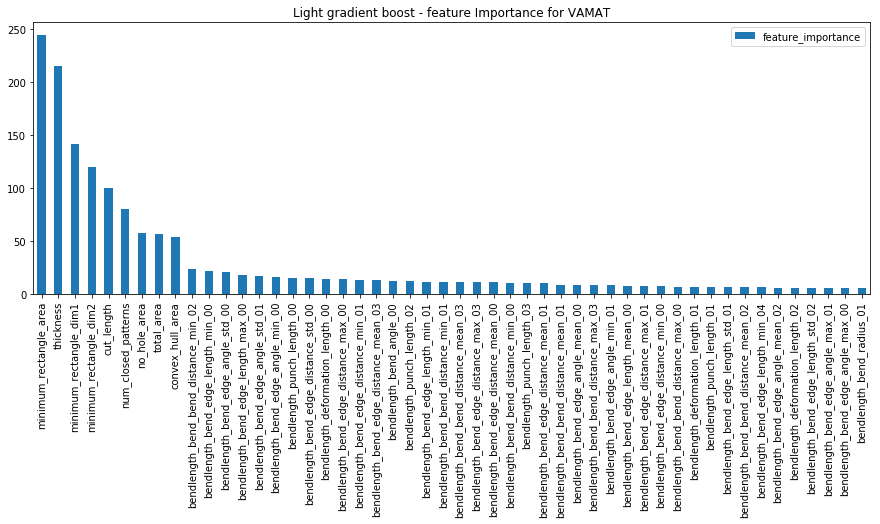

In [92]:
featimp = list(regpip.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - feature Importance for {target}')
plt.show()

# BOX-COX prediction

In [93]:
gbmlog = lgb.LGBMRegressor(objective='regression',
                        n_estimators=200,
                        random_state=0,
                       )
pipe = [('scaler', scaler), ('gbm', gbmlog)]
regpiplog = Pipeline(pipe)

In [94]:
regpiplog.fit(X_train[limitedset], y_train['logtarget'])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [95]:
param_grid = {
    'gbm__num_leaves':[20, 30, 40],
    'gbm__min_child_weight':np.logspace(-3,1,5),
    'gbm__min_data_in_leaf':[20,30,10],
    }

#MAE version
gridgbmlog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=5)

#MAPE version
#gridgbmlog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [96]:
gridgbmlog.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.10160718414849318, total=   1.1s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.10003563719479266, total=   2.0s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.0986337577620216, total=   1.9s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   13.6s


[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.09902879076233545, total=   2.6s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.10066572534422018, total=   3.3s
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.10083417382085372, total=   3.4s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.10011928306114043, total=   3.1s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.10078708727676985, total=   4.2s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=10, gbm__

[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.10160718414849318, total=   2.2s
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.10003563719479266, total=   1.9s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.01, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-0.09838442849253318, total=   4.5s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.0986337577620216, total=   2.4s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.09890027907481459, total=   2.7s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV] 

[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed:  1.2min


[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.10083417382085372, total=   2.6s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.10066572534422018, total=   3.5s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.09902879076233545, total=   3.4s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.10078708727676985, total=   3.8s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.10011928306114043, total=   3.9s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV] 

[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.10160718414849318, total=   2.2s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.10003563719479266, total=   2.1s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.0986337577620216, total=   1.9s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.10050228274567362, total=   3.4s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.09890027907481459, total=   3

[Parallel(n_jobs=-2)]: Done 135 out of 135 | elapsed:  2.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_spli...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__num_leaves': [20, 30, 40], 'gbm__min_child_weight': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'gbm__min_data_in_leaf': [20, 30, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=5)

In [97]:
print('target        :', target)
print('best score    :', gridgbmlog.best_score_)
print('best params   :', gridgbmlog.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridgbmlog.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)

target        : VAMAT
best score    : -0.0984350892692539
best params   : {'gbm__min_child_weight': 10.0, 'gbm__min_data_in_leaf': 10, 'gbm__num_leaves': 20}
MAPE test set : 9.621498548460576
MSE  test set : 4.569519817553421
MSE train set : 0.9142948986402057


In [98]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'min_child_weight': params['min_child_weight'],
        #'n_estimators': int(params['n_estimators']),
        'colsample_bytree': params['colsample_bytree'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': params['bagging_freq'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'max_depth':int(params['max_depth']),
        'learning_rate':params['learning_rate'],
        }
    
    clf = lgb.LGBMRegressor(objective='regression', n_estimators=300, **params)

    pipe = [('scaler', scaler), ('gbm', clf)]
    regpip = Pipeline(pipe)    
    
    #score = cross_val_score(regpip, X_train[limitedset], y_train['logtarget'], scoring='neg_mean_absolute_error', cv=3, n_jobs=-2).mean()
    print("MSE {:.3f} - params {}".format(score, params))
    return -score

space = {
    'num_leaves': hp.uniform('num_leaves', 5, 80),
    'min_data_in_leaf': hp.uniform('min_data_in_leaf', 5, 100),
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 20),
    #'n_estimators': hp.uniform('n_estimators', 100, 500),
    'colsample_bytree': hp.uniform('colsample_bytree', 0., 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0., 1.0),
    'bagging_freq': hp.randint('bagging_freq', 15),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
    'max_depth': hp.uniform('max_depth', 3, 20),
    'learning_rate': hp.uniform('learning_rate', 0.001, .2),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200)

NameError: name 'score' is not defined

In [ ]:
params = {
        'num_leaves': int(best['num_leaves']),
        'min_data_in_leaf': int(best['min_data_in_leaf']),
        'min_child_weight': best['min_child_weight'],
        #'n_estimators': int(best['n_estimators']),
        'colsample_bytree': best['colsample_bytree'],
        'bagging_fraction': best['bagging_fraction'],
        'bagging_freq': best['bagging_freq'],
        'reg_alpha': best['reg_alpha'],
        'reg_lambda': best['reg_lambda'],
        'max_depth':int(best['max_depth']),
        'learning_rate':best['learning_rate'],
        }

clflog = lgb.LGBMRegressor(objective='regression', n_estimators=300, **params)
pipe = [('scaler', scaler), ('gbm', clflog)]
regpiplog = Pipeline(pipe)
regpiplog.fit(X_train[limitedset], y_train['logtarget'])

preds = inv_boxcox(regpiplog.predict(X_test[limitedset]), lmbda)

msetest = mean_squared_error(y_test[target], preds)
mapetest = mean_absolute_percentage_error(y_test[target], preds)
msetrain = mean_squared_error(y_train[target], inv_boxcox(regpip.predict(X_train[limitedset]), lmbda))
print(target)
#print(clf.get_params())
print(params)
print('MAPE test:', mapetest)
print('MSE  test:', msetest)
print('MSE train:', msetrain)

In [ ]:
featimp = list(regpiplog.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - BOXCOX - feature Importance for {target}')
plt.show()

# Solution comparison

In [99]:
prediction_lgbm = gridgbm.predict(X_test[limitedset])
prediction_lgbm_log = inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda)

In [100]:
resultset = pd.DataFrame({f'target': y_test[target],
                          'pred_lgbm':prediction_lgbm,
                          'pred_lgbm_BOXCOX':prediction_lgbm_log,
                            }, index=y_test.index)
resultset.head()

,pred_lgbm,pred_lgbm_BOXCOX,target
COART,,,
L3041770,3.782991,3.568980,3.40
L6802530,0.119779,0.145859,0.15
L2605410,11.002178,11.338952,11.21
L7058820,8.564466,8.742682,6.70
L6011841,22.427714,21.929238,21.00


In [101]:
#Solution saving
resultset.to_csv(f'{target}_pred_lgbm.csv')


In [102]:
#MAPE
mape = mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm'])
mapelog = mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm_BOXCOX'])
print('mape', mape)
print('mapelog', mapelog)

mape 13.520260904603479
mapelog 9.621498548460576


In [103]:
#MSE
mse = mean_squared_error(resultset['target'], resultset['pred_lgbm'])
mselog = mean_squared_error(resultset['target'], resultset['pred_lgbm_BOXCOX'])
print('mse', mse)
print('mselog', mselog)

mse 5.354346800986602
mselog 4.569519817553421


In [104]:
resultset['MSE_lgbm'] = (resultset['target']-resultset['pred_lgbm'])**2
resultset['MSE_log_lgbm'] = (resultset['target']-resultset['pred_lgbm_BOXCOX'])**2
resultset.head()

,pred_lgbm,pred_lgbm_BOXCOX,target,MSE_lgbm,MSE_log_lgbm
COART,,,,,
L3041770,3.782991,3.568980,3.40,0.146682,0.028554
L6802530,0.119779,0.145859,0.15,0.000913,0.000017
L2605410,11.002178,11.338952,11.21,0.043190,0.016629
L7058820,8.564466,8.742682,6.70,3.476232,4.172550
L6011841,22.427714,21.929238,21.00,2.038367,0.863483


In [105]:
resultset['MSE_lgbm'].mean()

5.3543468009866055

In [106]:
#Data assembly
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,pred_lgbm,pred_lgbm_BOXCOX,target,MSE_lgbm,MSE_log_lgbm,cut_length,num_closed_patterns,num_open_patterns,total_area,...,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_RECTANGLE,SURF_COST_MPATTERN,APPROX_BEND_COST
0,L3041770,3.782991,3.568980,3.40,0.146682,0.028554,1836.297974,1,0,41957.070312,...,3.40,6.38,9.78,0.000009,0.000008,0.000010,3-5,0.000063,0.000081,1.063333
1,L6802530,0.119779,0.145859,0.15,0.000913,0.000017,374.891052,4,0,2171.109131,...,0.15,3.37,3.52,0.000009,0.000007,0.000010,1-2,0.000043,0.000060,1.123333
2,L2605410,11.002178,11.338952,11.21,0.043190,0.016629,3051.648682,16,0,140381.875000,...,11.21,5.43,16.64,0.000009,0.000008,0.000010,1-2,0.000066,0.000079,2.715000
3,L7058820,8.564466,8.742682,6.70,3.476232,4.172550,1793.807251,3,0,65955.062500,...,6.70,2.12,8.82,0.000007,0.000006,0.000007,0,0.000072,0.000086,2.120000
4,L6011841,22.427714,21.929238,21.00,2.038367,0.863483,2885.971436,9,0,263535.531250,...,21.00,5.38,26.38,0.000012,0.000008,0.000013,1-2,0.000050,0.000079,1.793333


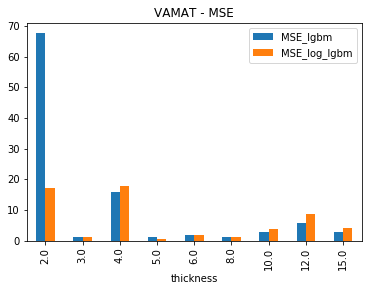

,MSE_lgbm,MSE_log_lgbm,COART
,mean,mean,count
thickness,,,
2.0,67.514304,16.979658,37
3.0,1.021805,1.044871,132
4.0,15.944759,17.827947,168
5.0,1.117611,0.400769,163
6.0,1.809660,1.968385,316
8.0,1.100474,1.126983,275
10.0,2.836056,3.791453,178
12.0,5.763176,8.624089,96


In [107]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('thickness').agg({'MSE_lgbm':['mean'],
                                         'MSE_log_lgbm':['mean'],
                                         'COART':['count']})

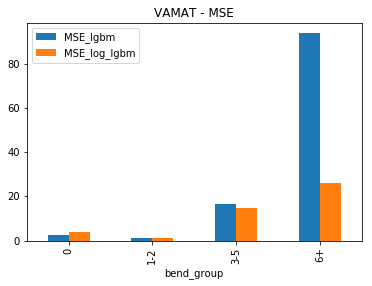

,MSE_lgbm,MSE_log_lgbm,COART
,mean,mean,count
bend_group,,,
0,2.353633,3.965626,578
1-2,1.263737,1.268513,625
3-5,16.674362,14.736440,184
6+,93.680784,26.228186,25


In [108]:
# Is the error sourced by number of errors ?

df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('bend_group').agg({'MSE_lgbm':['mean'],
                                         'MSE_log_lgbm':['mean'],
                                         'COART':['count']})

In [109]:
comparisonset['MAPE_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm']), axis=1)
comparisonset['MAPE_log_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm_BOXCOX']), axis=1)

comparisonset[['target', 'pred_lgbm', 'MAPE_error', 'pred_lgbm_BOXCOX', 'MAPE_log_error']].head()

,target,pred_lgbm,MAPE_error,pred_lgbm_BOXCOX,MAPE_log_error
0,3.40,3.782991,11.264445,3.568980,4.969996
1,0.15,0.119779,20.147434,0.145859,2.760886
2,11.21,11.002178,1.853902,11.338952,1.150330
3,6.70,8.564466,27.827844,8.742682,30.487793
4,21.00,22.427714,6.798637,21.929238,4.424941


In [110]:
#MAPE
comparisonset['MAPE_error'].mean()

13.520260904603456

In [125]:
#If bends use this line
if target == 'VALAJOUT' or target == 'VALTOT':
    df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm','MAPE_error', 'MAPE_log_error', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])

#If no bends use this line
if target == 'VAMAT':
    df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm','MAPE_error', 'MAPE_log_error', 'thickness', 'COART']].groupby(['thickness'])

perf = df.agg({'MSE_lgbm': ['mean', 'max'],
        'MSE_log_lgbm': ['mean', 'max'],
        'MAPE_error': ['mean', 'max'],
        'MAPE_log_error': ['mean', 'max'],
        'COART':['count'] })
perf

MSE_lgbm              MSE_log_lgbm              MAPE_error  \
                mean          max         mean          max       mean   
thickness                                                                
2.0        67.514304  1138.855883    16.979658   245.385872  31.546343   
3.0         1.021805    43.794354     1.044871    19.620337  12.252383   
4.0        15.944759  2183.780499    17.827947  2058.046226  12.712693   
5.0         1.117611   125.823847     0.400769    30.107493  10.968256   
6.0         1.809660   144.406108     1.968385   227.215527  13.330492   
8.0         1.100474    48.161437     1.126983    54.914004  10.582822   
10.0        2.836056   120.743972     3.791453   160.590057  11.413460   
12.0        5.763176   284.940986     8.624089   432.300550  24.081405   
15.0        2.850520    27.129527     4.060636    82.616585  19.497846   

                      MAPE_log_error             COART  
                  max           mean         max count  
thickness                                               
2.0        188.952625      16.026100   87.708831    37  
3.0        130.574162       8.156769   42.808905   132  
4.0         68.374298       8.703361   52.373302   168  
5.0         69.965809       7.496786   45.428488   163  
6.0         63.206472       8.743217   45.023163   316  
8.0        138.128284       9.189638  127.351217   275  
10.0        97.587533       9.255067  112.543634   178  
12.0       170.544622      16.060978   89.333740    96  
15.0        99.044764      16.010492   49.193940    47

In [131]:
perf.loc[2.]['MSE_lgbm', 'mean']


67.51430408338916

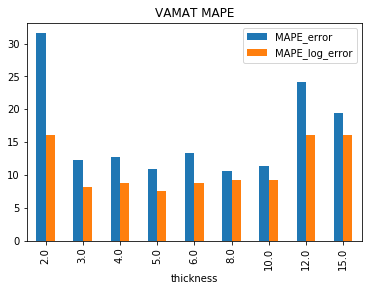

,MAPE_error,MAPE_log_error,COART
,mean,mean,count
thickness,,,
2.0,31.546343,16.026100,37
3.0,12.252383,8.156769,132
4.0,12.712693,8.703361,168
5.0,10.968256,7.496786,163
6.0,13.330492,8.743217,316
8.0,10.582822,9.189638,275
10.0,11.413460,9.255067,178
12.0,24.081405,16.060978,96


In [112]:
df = comparisonset[['MAPE_error', 'MAPE_log_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.show()
comparisonset.groupby('thickness').agg({'MAPE_error':['mean'],
                                         'MAPE_log_error':['mean'],
                                         'COART':['count']})

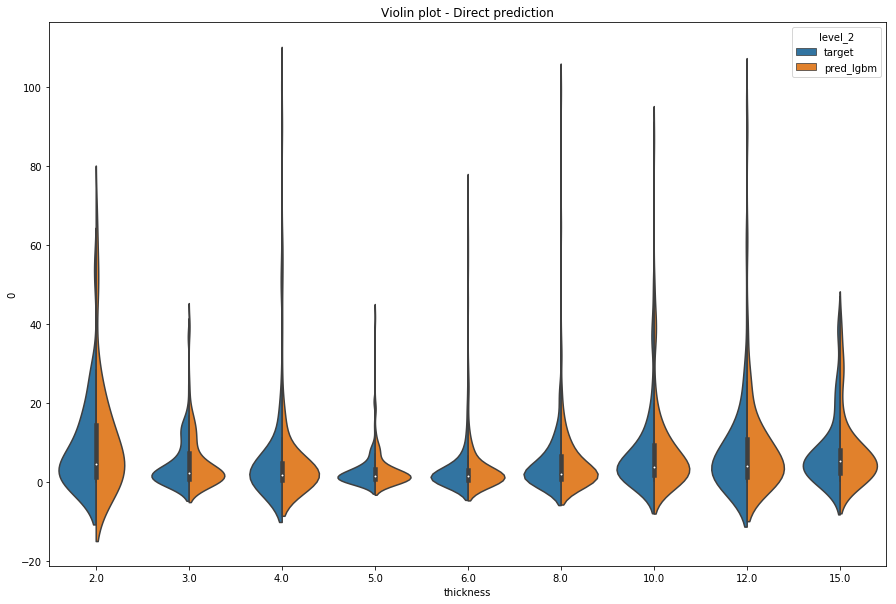

In [113]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title('Violin plot - Direct prediction')
plt.show()

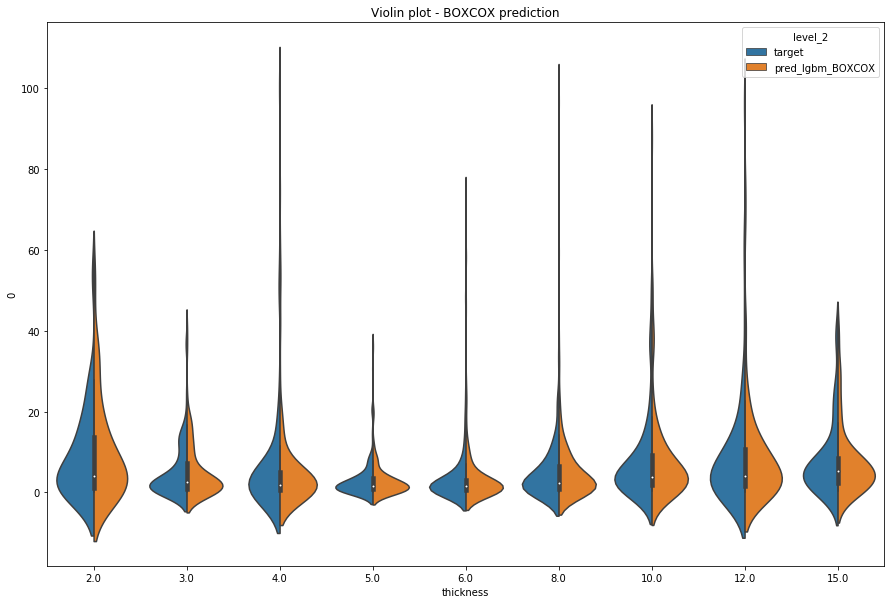

In [114]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm_BOXCOX', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title('Violin plot - BOXCOX prediction')
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


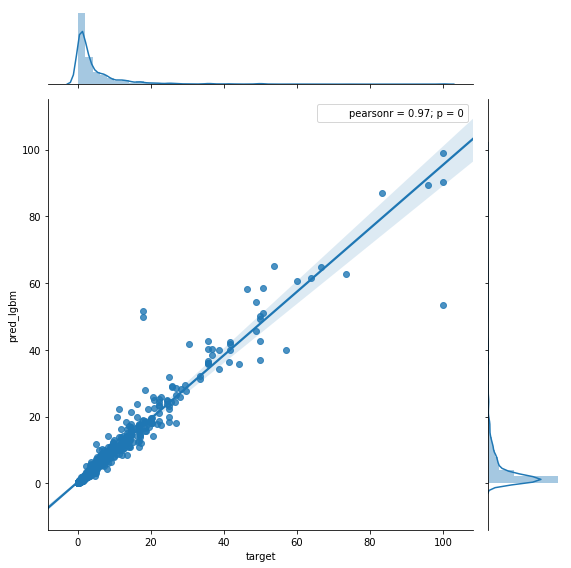

In [115]:
# No BOXCOX
sns.jointplot(x='target', y='pred_lgbm', data=comparisonset, kind='reg', size=8)
plt.show()

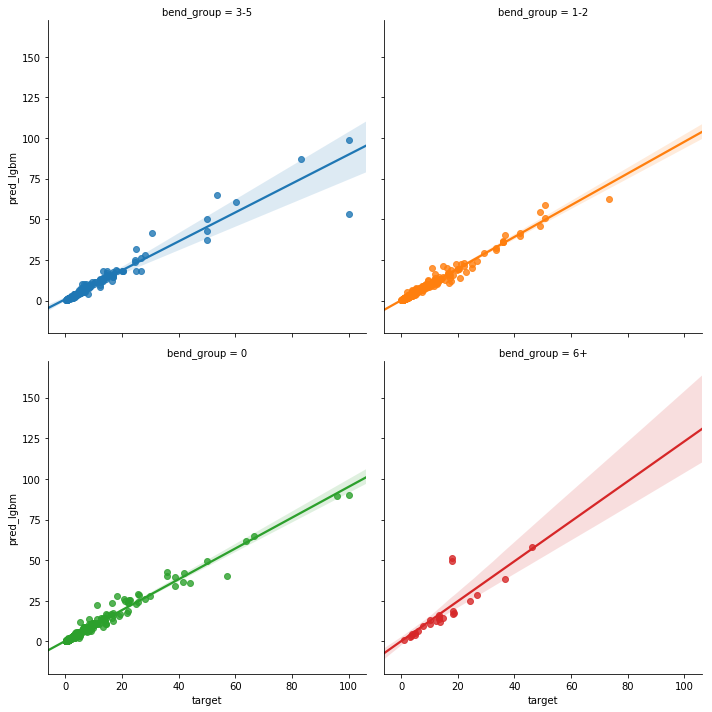

In [116]:
sns.lmplot(x='target',
           y='pred_lgbm',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           legend=True)
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


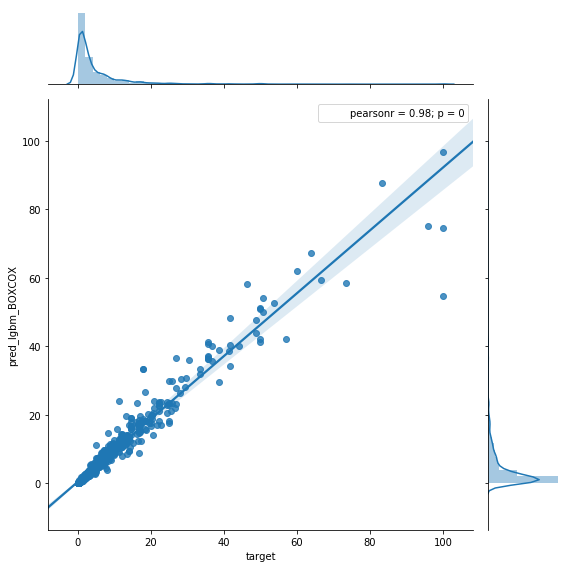

In [117]:
# With BOXCOX
sns.jointplot(x='target', y='pred_lgbm_BOXCOX', data=comparisonset, kind='reg',size=8)
plt.show()

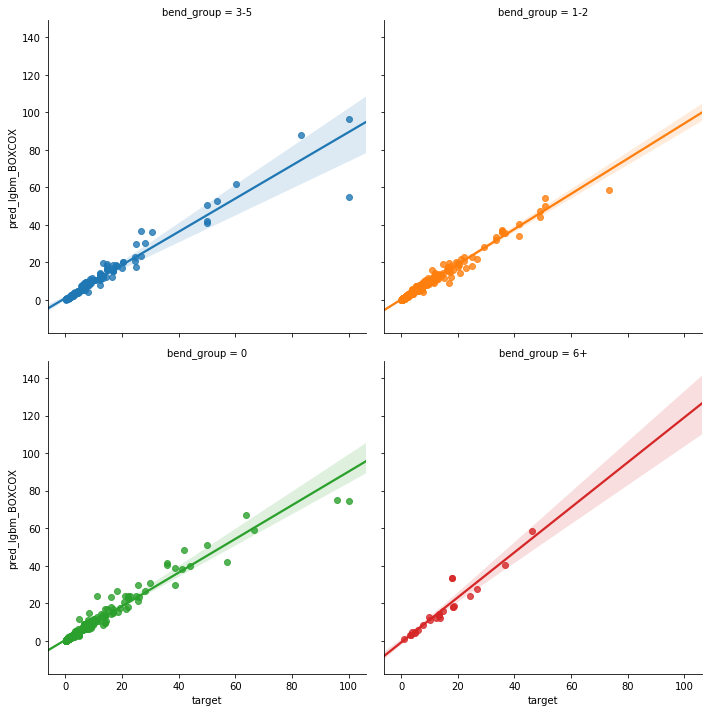

In [118]:
sns.lmplot(x='target',
           y='pred_lgbm_BOXCOX',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           #palette="Set1",
           legend=True),
plt.show()

In [119]:
df = comparisonset[['MSE_lgbm', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_lgbm'].nlargest(5)

worst.to_csv('../Y3 - Sample data/Z3 - outliers.csv')
print(worst.shape)
worst

(45,)


thickness  COART   
2.0        L7067210    1138.855883
           L7070650    1018.117805
           L2503310     133.652241
           L6006290      81.841534
           L7012180      77.650439
3.0        L7069760      43.794354
           L1608760      15.048703
           L8037510      12.397264
           L5701480      10.208145
           L3045330       8.252012
4.0        L1608630    2183.780499
           L6707490     168.527623
           L3119040      98.188970
           L7051081      60.892907
           L8055410      52.662257
5.0        L8834370     125.823847
           L2608480      16.924910
           L7018041       7.720496
           L7013791       5.033992
           L7013792       5.033992
6.0        L7065230     144.406108
           L8045330     117.624794
           L6005820      94.985911
           L6000550      55.528556
           L3020640      29.218845
8.0        L8024970      48.161437
           L8049000      47.698557
           L7080610      30.071939


In [132]:
type(worst)

pandas.core.series.Series

In [120]:
#comparison

#Thickness filter
df = comparisonset[comparisonset['thickness'] == 8]

#Cost filter Max
#df = df[df[target]<15]

#Cost filter Min
#df = df[df[target]>10] #bend_count

#Min rectangle area
#df = df[df['minimum_rectangle_area'] < 700000]
df = df[df['minimum_rectangle_area'] > 10000]

#bend_count filter
df = df[df['bend_count'] == 4]

#df[df['COART']=='L3128890'].T
df.T

,490,535,562,593,702,738
COART,L3070880,L3108010,L2509970,L2609180,L2512260,L2607650
pred_lgbm,8.28011,2.30129,3.07136,99.0435,1.92123,18.1977
pred_lgbm_BOXCOX,8.03087,2.5747,3.04131,96.6672,2.0486,16.8616
target,7.21,2.6,2.6,100.08,2,20.02
MSE_lgbm,1.14514,0.0892276,0.22218,1.07439,0.00620527,3.32062
MSE_log_lgbm,0.673833,0.000639891,0.194756,11.6475,0.00236224,9.97573
cut_length,2099.71,1065.71,1323.45,18804.5,1143.75,3137.92
num_closed_patterns,3,7,4,173,3,3
num_open_patterns,0,0,0,0,0,0
total_area,54361.4,25374.2,43451.9,1.64351e+06,36513.2,113772


In [121]:
dataset.loc[['L8835850']].T
#comparisonset[comparisonset['COART'] == 'L3131690']

COART,L8835850
cut_length,6989.19
num_closed_patterns,19
num_open_patterns,0
total_area,196112
minimum_rectangle_area,626653
minimum_rectangle_dim1,1322.67
minimum_rectangle_dim2,473.779
convex_hull_area,530068
no_hole_area,221461
thickness,8
